# AxCaliber with time-dependent zeppelin


\begin{equation}
E_{\textrm{AxCaliber}}^{\textrm{Temporal}}= \underbrace{(1-f_r)\overbrace{E_h(b,\textbf{n},\lambda_\parallel,D_{\infty},A)}^{\textrm{Zeppelin}}}_{\textrm{Extra-Axonal}} + \underbrace{f_r \overbrace{\Gamma(\alpha,\beta)}^{\textrm{Gamma Distribution}}*_{\mathbb{R}}\overbrace{E_r(\cdot|D_\perp)}^{\textrm{Cylinder}}}_{\textrm{Intra-Axonal}}
\end{equation}




\begin{equation}
 E_h(b,\textbf{n},\lambda_\parallel,D_{\infty},A)=\exp(-b\textbf{n}^T(\textbf{R}\textbf{D}^h_{\textrm{diag}}\textbf{R}^T)\textbf{n})\quad\textrm{with}\quad
 \textbf{D}^h_{\textrm{diag}}=
\begin{pmatrix}
  \lambda_\parallel & 0 & 0  \\
  0 & D_{\infty}+A\frac{\ln(\Delta/\delta)+3/2}{\Delta-\delta/3} & 0  \\
  0  & 0  & D_{\infty}+A\frac{\ln(\Delta/\delta)+3/2}{\Delta-\delta/3}
 \end{pmatrix}
\end{equation}

# AxCaliber model with time-dependent zeppelin

In [5]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions import distribute_models

temporal_zeppelin = gaussian_models.G3TemporalZeppelin()
cylinder = cylinder_models.C4CylinderGaussianPhaseApproximation()
gamma_cylinder = distribute_models.DD1GammaDistributed(models=[cylinder])

Then put the models together in a MultiCompartmentModel and display the parameters

In [6]:
from dmipy.core import modeling_framework
temporal_AxCaliber = modeling_framework.MultiCompartmentModel(models=[temporal_zeppelin, gamma_cylinder])
temporal_AxCaliber.parameter_cardinality

OrderedDict([('G3TemporalZeppelin_1_mu', 2),
             ('DD1GammaDistributed_1_DD1Gamma_1_beta', 1),
             ('G3TemporalZeppelin_1_lambda_inf', 1),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par',
              1),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu',
              2),
             ('G3TemporalZeppelin_1_A', 1),
             ('DD1GammaDistributed_1_DD1Gamma_1_alpha', 1),
             ('G3TemporalZeppelin_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

The data we will fit is measured only along 2 gradients perpendicular to the fiber axis (along x and y axis). This means there is no data that provides information to fit parallel diffusivity "lambda_par" or the axon orientation "mu". To not fit these superfluous parameters we fix mu along the z-axis and give lambda_par an arbitrary value (it will not affect the results).

In [7]:
temporal_AxCaliber.set_fixed_parameter(
    'G3TemporalZeppelin_1_lambda_par', 1.5e-9)
temporal_AxCaliber.set_fixed_parameter(
    'G3TemporalZeppelin_1_mu', [0, 0])
temporal_AxCaliber.set_fixed_parameter(
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par', 1.5e-9)
temporal_AxCaliber.set_fixed_parameter(
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu', [0, 0])

# Load Monte Carlo simulated data

In [34]:
from dmipy.data import saved_data
#scheme_spinal_cord, data_spinal_cord = saved_data.duval_cat_spinal_cord_2d()

In [35]:
scheme_, data_ = saved_data.deSantis_camino_data()

In [36]:
scheme_.print_acquisition_info

Acquisition scheme summary

total number of measurements: 53
number of b0 measurements: 17
number of DWI shells: 36

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |0                        |17.0       |48.0      |83.0 
1           |1         |500             |23                       |17.0       |48.0      |83.0 
2           |1         |999             |33                       |17.0       |48.0      |83.0 
3           |1         |2000            |47                       |17.0       |48.0      |83.0 
4           |1         |3999            |67                       |17.0       |48.0      |83.0 
5           |2         |0               |0                        |17.0       |60.0      |95.0 
6           |1         |499             |21                       |17.0       |60.0      |95.0 
7           |1         |1000            |29                       |17.0       |60.0      |95.0 
8           |1    

We reproduce a PGSE acquisition scheme si based on De Santis STEAM acquistion scheme...

loading the simulated data ... For our configuration, 50 repetitions were generated, on which rician noise was added with SNR=30

In [38]:
data_.shape

(50, 54)

# Fit time-dependent AxCaliber model to simulated data

In [12]:
temporal_AxCaliber_fit = temporal_AxCaliber.fit(
    acquisition_scheme, np.atleast_2d(generated_signal), solver='mix', 
    maxiter=100, use_parallel_processing=True)

Using parallel processing with 4 workers.
Setup MIX optimizer in 5.72204589844e-05 seconds
Fitting of 50 voxels complete in 752.048654079 seconds.
Average of 15.0409730816 seconds per voxel.


In [13]:
temporal_AxCaliber_fit.fitted_parameters

{'DD1GammaDistributed_1_DD1Gamma_1_alpha': array([ 11.71691344,  29.99996639,   0.59413706,  22.03533648,
          6.3750363 ,   1.71542792,  17.64274369,   6.796168  ,
         10.9576752 ,   0.39249578,  30.        ,   6.33258956,
         15.96886754,  27.75734593,   1.27360472,  11.5772134 ,
          1.32061208,  10.32329497,   6.7892918 ,  30.        ,
         30.        ,   4.30294986,   0.9464993 ,   0.44885595,
         22.44853162,   0.1       ,   1.1581099 ,  29.99998885,
          6.31838761,  30.        ,  16.76993216,  17.63949051,
          3.14832868,   3.07701092,   0.72256856,  15.7943821 ,
         14.53866174,   8.15638063,  15.23014878,   0.57755865,
          0.14381948,  29.46453156,   1.63303866,   2.68075589,
          0.38841089,  29.99992325,   8.05405672,  27.53217344,
          6.19974924,   0.21657462]),
 'DD1GammaDistributed_1_DD1Gamma_1_beta': array([  3.43975212e-09,   1.35879413e-07,   7.18127062e-07,
          1.05466663e-08,   3.40952166e-08,   7.8

In [14]:
A_s = temporal_AxCaliber_fit.fitted_parameters['G3TemporalZeppelin_1_A']
D_inf_s = temporal_AxCaliber_fit.fitted_parameters['G3TemporalZeppelin_1_lambda_inf']
alpha_s = temporal_AxCaliber_fit.fitted_parameters['DD1GammaDistributed_1_DD1Gamma_1_alpha']
beta_s = temporal_AxCaliber_fit.fitted_parameters['DD1GammaDistributed_1_DD1Gamma_1_beta']

In [15]:
A_s.mean()*1e12, A_s.std()*1e12

(1.3547630753944138, 2.4543176199101562)

In [16]:
D_inf_s.mean()*1e9, D_inf_s.std()*1e9

(1.1769976165665323, 0.11982352108982226)

In [17]:
np.mean(alpha_s * beta_s * 2e6), np.std(alpha_s * beta_s * 2e6)

(2.5101838659918734, 3.6395169863865213)

# Visualize fitted parameters

In [18]:
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
kernel = stats.gaussian_kde(A_s)
kernel2 = stats.gaussian_kde(D_inf_s)

In [31]:
ind = np.linspace(A_s.min(), A_s.max(), 50)
ind2 = np.linspace(D_inf_s.min(), D_inf_s.max(), 50)

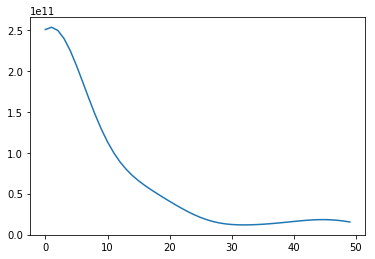

In [32]:
plt.plot(kernel.evaluate(ind))
plt.show()

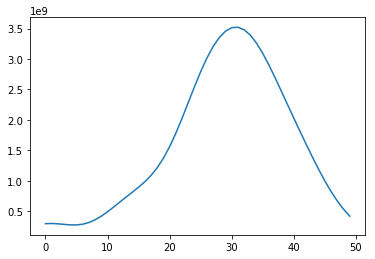

In [33]:
plt.plot(kernel2.evaluate(ind2))
plt.show()